### Imports

In [2]:
import cv2
import time

import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
from helpers.limbus_detection import detect_limbus
from helpers.misc import \
    jiggle_circle, tighten_circle, repair_bbox, is_circle_enclosed, geometric_median
from helpers.view_detection import get_view_mask

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


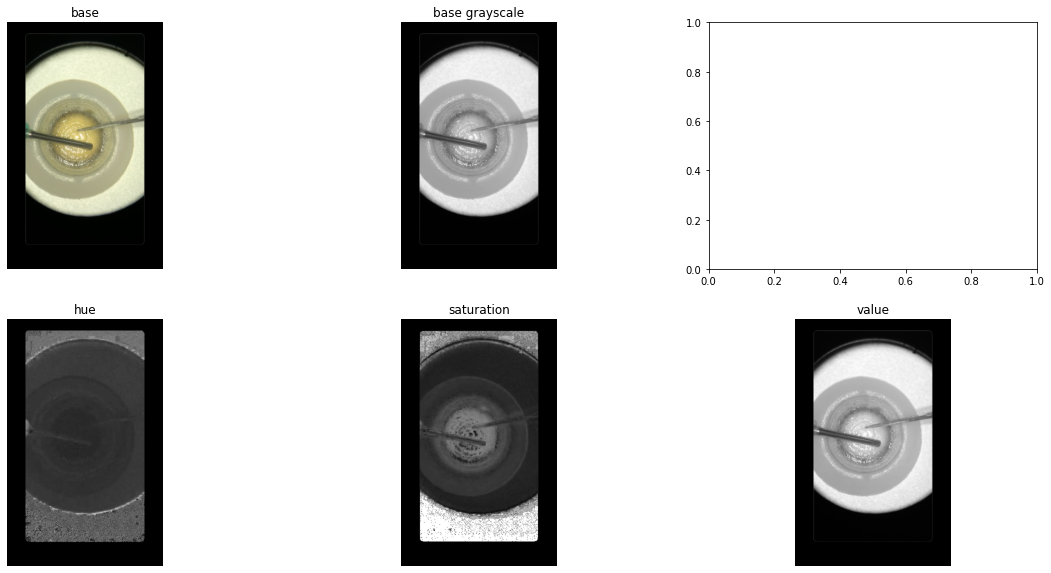

size: 312x496


In [12]:
scale = 0.33

base = cv2.imread('data/artificial/bioniko_rhexis_base4.png', cv2.IMREAD_COLOR)
base = cv2.resize(base, (0,0), fx=scale, fy=scale)

base_rgb = cv2.cvtColor(base, cv2.COLOR_BGR2RGB)
base_gray = cv2.cvtColor(base, cv2.COLOR_BGR2GRAY)
base_hsv = cv2.cvtColor(base, cv2.COLOR_BGR2HSV)

base_hue = base_hsv[:,:,0]
base_saturation = base_hsv[:,:,1]
base_value = base_hsv[:,:,2]

fig, ((plot1, plot2, _), (plot3, plot4, plot5)) = plt.subplots(2, 3, figsize=(20,10))
plot1.set_title('base')
plot1.imshow(base_rgb)
plot1.axis('off')

plot2.set_title('base grayscale')
plot2.imshow(base_gray, cmap=plt.cm.gray)
plot2.axis('off')

plot3.set_title('hue')
plot3.imshow(base_hue, cmap=plt.cm.gray)
plot3.axis('off')

plot4.set_title('saturation')
plot4.imshow(base_saturation, cmap=plt.cm.gray)
plot4.axis('off')

plot5.set_title('value')
plot5.imshow(base_value, cmap=plt.cm.gray)
plot5.axis('off')

plt.show()

print('size: %dx%d' % (base.shape[1], base.shape[0]))

### Defining rhexis model constants

<table><tr>
    <td><img src="data/demonstrations/rhexis_full_diameter.png" width=200></td>
    <td><img src="data/demonstrations/rhexis_pupil_diameter.png" width=200></td>
</tr></table>

In [13]:
measurements = [664, 664, 654, 663, 652] # for diameter
RHEXIS_FULL_RADIUS = np.mean(measurements)/2

print('RHEXIS_FULL_RADIUS', RHEXIS_FULL_RADIUS)

RHEXIS_FULL_RADIUS 329.7


In [14]:
measurements = [431, 420, 430, 430, 429] # for diameter
RHEXIS_PUPIL_RADIUS = np.mean(measurements)/2

print('RHEXIS_PUPIL_RADIUS', RHEXIS_PUPIL_RADIUS)

RHEXIS_PUPIL_RADIUS 214.0


In [15]:
PUPIL_TO_FULL_RATIO = RHEXIS_PUPIL_RADIUS/ RHEXIS_FULL_RADIUS
print('pupil to full radia ratio', PUPIL_TO_FULL_RATIO)

pupil to full radia ratio 0.6490749165908402


### Trying to segment pupil color

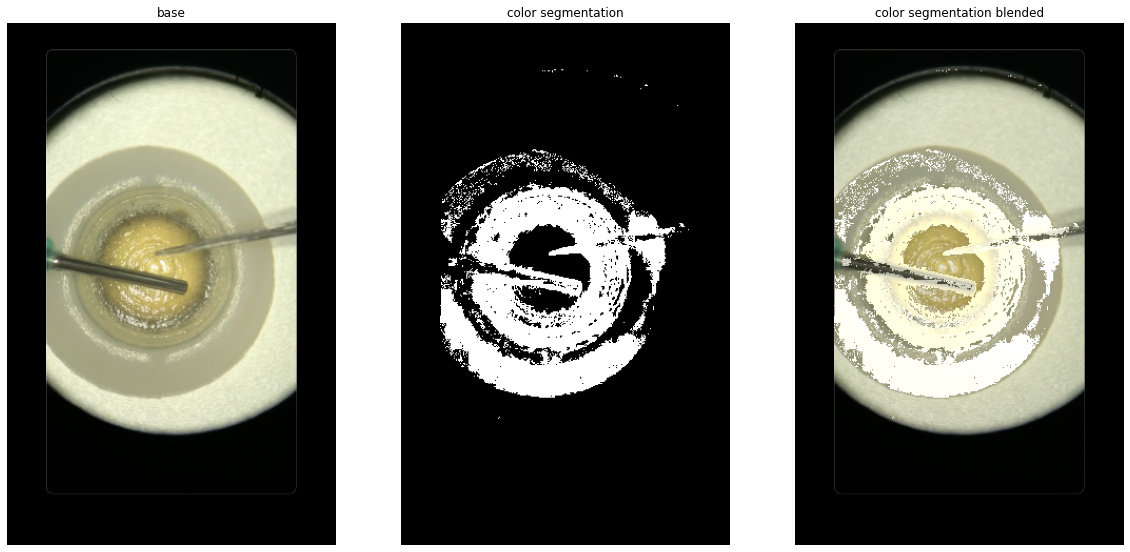

In [16]:
# old, prob too bright (default)
pupil_color_lth = np.array([10, 40, 40])
pupil_color_uth = np.array([30, 180, 180])

# slightly better; would require correction
# pupil_color_lth = np.array([16, 97, 193])
# pupil_color_uth = np.array([29, 153, 255])

# for the more defined outer ring; bad for zoomed in cases
# pupil_color_lth = np.array([15, 38, 140])
# pupil_color_uth = np.array([30, 127, 230])

# oldest; from initial tests; segments the whole of the eye
# pupil_color_lth = np.array([10, 40, 40])
# pupil_color_uth = np.array([30, 180, 180])

base_pupil_thres = cv2.inRange(base_hsv, pupil_color_lth, pupil_color_uth)

base_blended = cv2.addWeighted(
    base_rgb,
    0.9,
    cv2.cvtColor(base_pupil_thres, cv2.COLOR_GRAY2RGB),
    0.5,
    0.0
)

fig, plots = plt.subplots(1, 3, figsize=(20,10))
plots[0].set_title('base')
plots[0].imshow(base_rgb)
plots[0].axis('off')

plots[1].set_title('color segmentation')
plots[1].imshow(base_pupil_thres, cmap='gray')
plots[1].axis('off')

plots[2].set_title('color segmentation blended')
plots[2].imshow(base_blended)
plots[2].axis('off')

plt.show()

### Displaying top ten detected circles

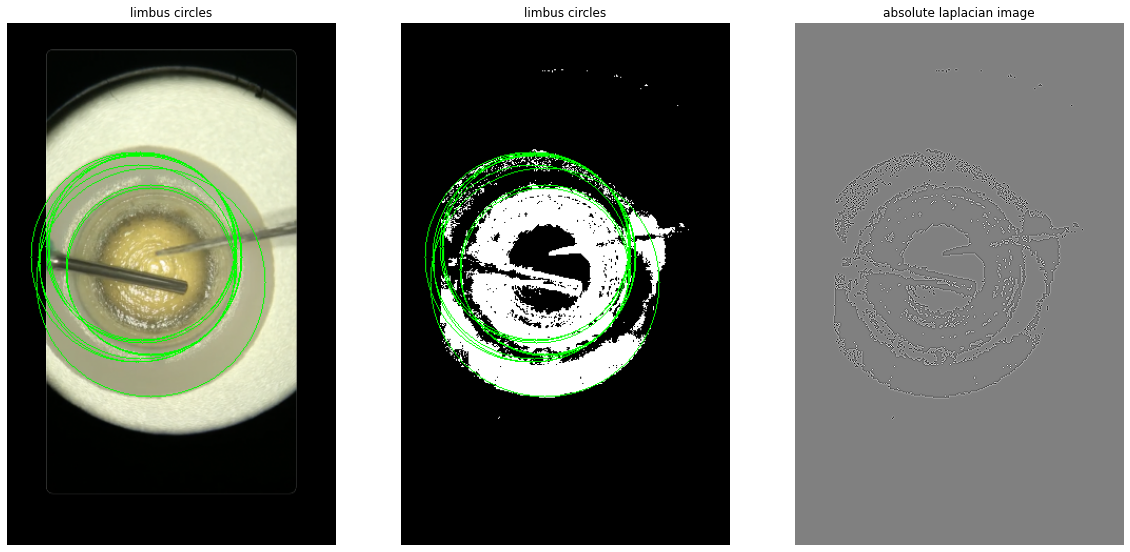

In [17]:
circles = detect_limbus(
    base_pupil_thres,
    return_all=True
)

base_copy = base_rgb.copy()
base_pupil_thres_copy = cv2.cvtColor(base_pupil_thres, cv2.COLOR_GRAY2RGB)

for circle in circles[:10]:
    cv2.circle(base_copy, tuple(np.round(circle[:2]).astype('int')), 
               round(circle[2]), (0,255,0), thickness=1)
    cv2.circle(base_pupil_thres_copy, tuple(np.round(circle[:2]).astype('int')), 
               round(circle[2]), (0,255,0), thickness=1)

fig, plots = plt.subplots(1, 3, figsize=(20,10))
plots[0].set_title('limbus circles')
plots[0].imshow(base_copy)
plots[0].axis('off')

plots[1].set_title('limbus circles')
plots[1].imshow(base_pupil_thres_copy)
plots[1].axis('off')

plots[2].set_title('absolute laplacian image')
plots[2].imshow(cv2.Laplacian(base_pupil_thres, cv2.CV_16S), cmap=plt.cm.gray)
plots[2].axis('off')

plt.show()

### Displaying the best circle

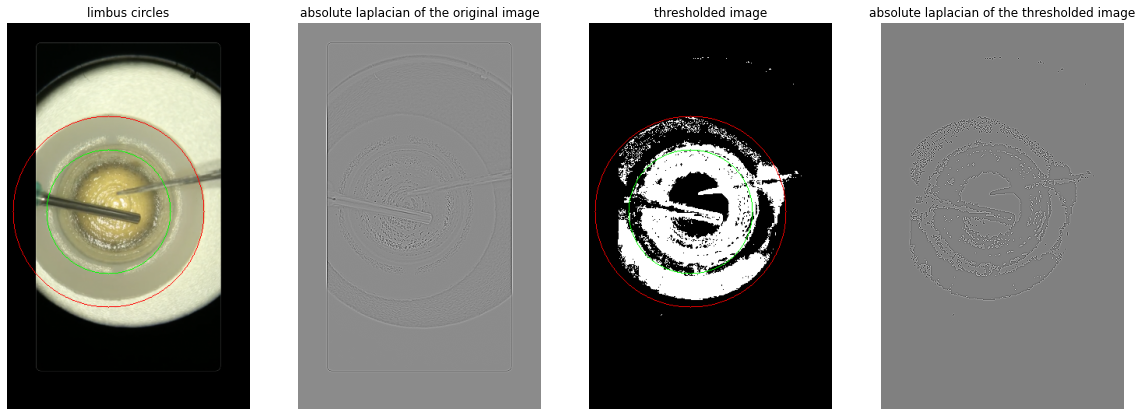

In [18]:
best_circle = detect_limbus(
    base_pupil_thres,
    validation='inout', 
    validation_mode='max'
)

base_copy = base_rgb.copy()
base_pupil_thres_copy = cv2.cvtColor(base_pupil_thres, cv2.COLOR_GRAY2RGB)

cv2.circle(base_copy, tuple(np.round(best_circle[:2]).astype('int')), 
           round(best_circle[2]), (0,255,0), thickness=1)
cv2.circle(base_pupil_thres_copy, tuple(np.round(best_circle[:2]).astype('int')), 
           round(best_circle[2]), (0,255,0), thickness=1)

cv2.circle(base_copy, tuple(np.round(best_circle[:2]).astype('int')), 
           round(best_circle[2]/PUPIL_TO_FULL_RATIO), (255,0,0), thickness=1)
cv2.circle(base_pupil_thres_copy, tuple(np.round(best_circle[:2]).astype('int')), 
           round(best_circle[2]/PUPIL_TO_FULL_RATIO), (255,0,0), thickness=1)

fig, plots = plt.subplots(1, 4, figsize=(20,10))
plots[0].set_title('limbus circles')
plots[0].imshow(base_copy)
plots[0].axis('off')

plots[1].set_title('absolute laplacian of the original image')
plots[1].imshow(cv2.Laplacian(base_gray, cv2.CV_16S), cmap=plt.cm.gray)
plots[1].axis('off')

plots[2].set_title('thresholded image')
plots[2].imshow(base_pupil_thres_copy)
plots[2].axis('off')

plots[3].set_title('absolute laplacian of the thresholded image')
plots[3].imshow(cv2.Laplacian(base_pupil_thres, cv2.CV_16S), cmap=plt.cm.gray)
plots[3].axis('off')

plt.show()

### Video demo without color thresholding, aiming to detect the outer edge of the whole eye

In [19]:
cap = cv2.VideoCapture('/Users/mirek/Desktop/rhexis_input_long.mp4')
_, frame = cap.read()
view_mask, view_circle = get_view_mask(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY), return_circle=True)

while cap.isOpened():
    ret, frame = cap.read() 

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) 

    #     best_circle = detect_limbus(gray, validation='inout', validation_mode='max')
    circles = detect_limbus(gray, view_mask=view_mask, return_all=True)
    if (circles is not None):
        best_circle = None
        for circle in circles:
            # similiarity of the detected circle and enclosure checks
            if any(np.abs(circle - view_circle) > np.array([20, 20, 20])):
                best_circle = circle
                break
        
        if best_circle is not None:
            cv2.circle(frame, tuple(np.round(best_circle[:2]).astype('int')), 
                   round(best_circle[2]), (0,255,0), thickness=1)
            
#         cv2.circle(frame, tuple(np.round(view_circle[:2]).astype('int')), 
#                    round(view_circle[2]), (0,0,255), thickness=1)

    cv2.imshow('detection', frame)
    cv2.imshow('view_mask', view_mask)

    if cv2.waitKey(25) == ord('q'): 
        break

cap.release() 
for _ in range(10):
    cv2.destroyAllWindows()
    cv2.waitKey(1)

### Center detection using morphology and other stuff

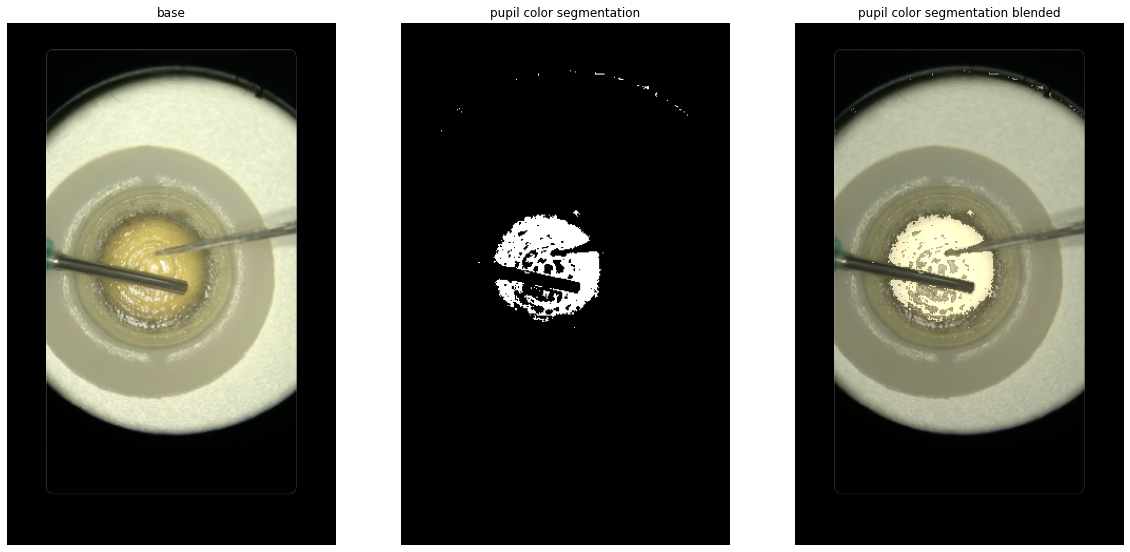

In [33]:
# pupil_color_lth = np.array([16, 97, 193])
# pupil_color_uth = np.array([29, 153, 255])

pupil_color_lth = np.array([10, 100, 20])
pupil_color_uth = np.array([35, 255, 255])

base_pupil_thres = cv2.inRange(base_hsv, pupil_color_lth, pupil_color_uth)
base_blended = cv2.addWeighted(
    base_rgb,
    0.8,
    cv2.cvtColor(base_pupil_thres, cv2.COLOR_GRAY2RGB),
    0.5,
    0.0
)

fig, plots = plt.subplots(1, 3, figsize=(20,10))
plots[0].set_title('base')
plots[0].imshow(base_rgb)
plots[0].axis('off')

plots[1].set_title('pupil color segmentation')
plots[1].imshow(base_pupil_thres, cmap='gray')
plots[1].axis('off')

plots[2].set_title('pupil color segmentation blended')
plots[2].imshow(base_blended)
plots[2].axis('off')

plt.show()

Finding contours in the thresholded image

total of found contours: 65


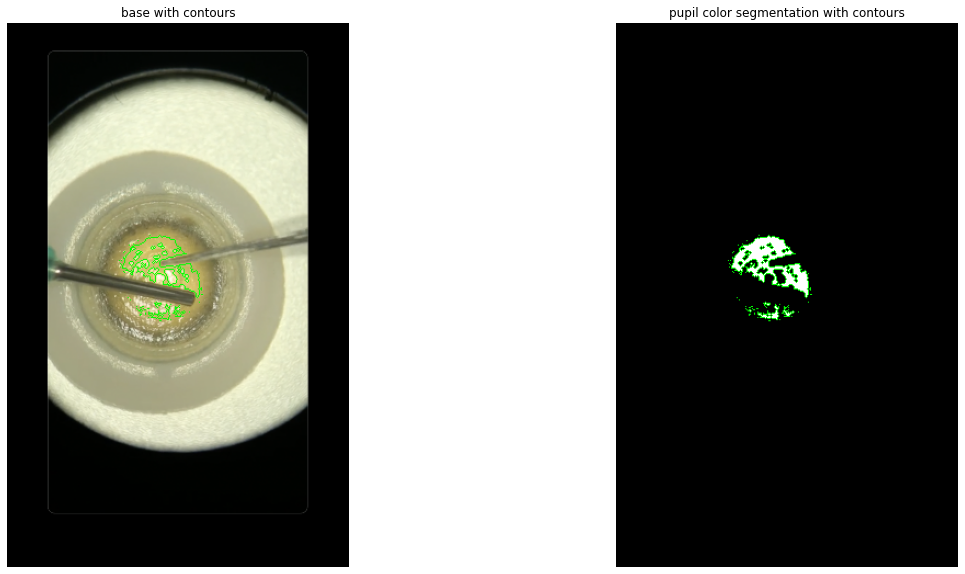

In [21]:
contours, _ = cv2.findContours(base_pupil_thres, 1, 2)

base_copy = base_rgb.copy()
cv2.drawContours(base_copy, contours, -1, (0,255,0))

base_pupil_thres_copy = cv2.cvtColor(base_pupil_thres, cv2.COLOR_GRAY2BGR)
cv2.drawContours(base_pupil_thres_copy, contours, -1, (0,255,0))

print('total of found contours: %d' % len(contours))

fig, plots = plt.subplots(1, 2, figsize=(20,10))
plots[0].set_title('base with contours')
plots[0].imshow(base_copy)
plots[0].axis('off')

plots[1].set_title('pupil color segmentation with contours')
plots[1].imshow(base_pupil_thres_copy, cmap='gray')
plots[1].axis('off')

plt.show()

Morphological processing step

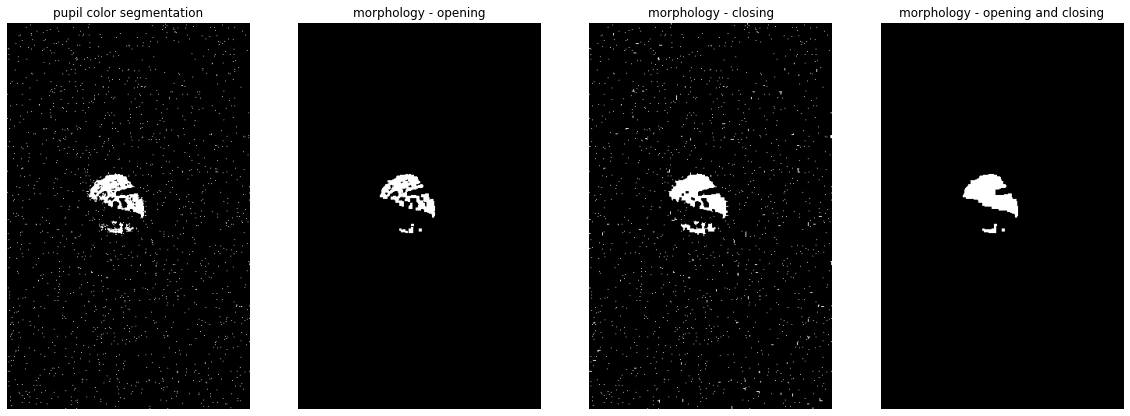

In [23]:
kernel = np.ones((3,3),np.uint8) # could be automatically set based on moments

base_pupil_thres_copy = base_pupil_thres.copy()
noise = np.random.rand(*base_pupil_thres_copy.shape)
base_pupil_thres_copy[noise > 0.99] = 255

opening = cv2.morphologyEx(base_pupil_thres_copy, cv2.MORPH_OPEN, kernel)
closing = cv2.morphologyEx(base_pupil_thres_copy, cv2.MORPH_CLOSE, kernel)
opening_closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations=3)


fig, plots = plt.subplots(1, 4, figsize=(20,10))
plots[0].set_title('pupil color segmentation')
plots[0].imshow(base_pupil_thres_copy, cmap='gray')
plots[0].axis('off')

plots[1].set_title('morphology - opening')
plots[1].imshow(opening, cmap='gray')
plots[1].axis('off')

plots[2].set_title('morphology - closing')
plots[2].imshow(closing, cmap='gray')
plots[2].axis('off')

plots[3].set_title('morphology - opening and closing')
plots[3].imshow(opening_closing, cmap='gray')
plots[3].axis('off')

plt.show()

Finding the center with other structures in the image

In [ ]:
def ransac_centroid:
    

In [20]:
pupil_color_lth = np.array([16, 97, 193])
pupil_color_uth = np.array([29, 153, 255])

cap = cv2.VideoCapture('/Users/mirek/Desktop/rhexis_input_long.mp4')
_, frame = cap.read()
view_mask, view_circle = get_view_mask(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY), return_circle=True)

while cap.isOpened():
    ret, frame = cap.read() 

    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV) 
    pupil_thres = cv2.inRange(hsv, pupil_color_lth, pupil_color_uth)
    blended = cv2.addWeighted(
        frame,
        0.8,
        cv2.cvtColor(pupil_thres, cv2.COLOR_GRAY2BGR),
        0.5,
        0.0
    )

    cv2.imshow('original', frame)
    cv2.imshow('thresholded', pupil_thres)
    cv2.imshow('blend', blended)

    if cv2.waitKey(25) == ord('q'): 
        break

cap.release() 
for _ in range(10):
    cv2.destroyAllWindows()
    cv2.waitKey(1)

In [ ]:
# pupil_color_lth = np.array([16, 97, 193])
# pupil_color_uth = np.array([29, 153, 255])

pupil_color_lth = np.array([15, 100, 50])
pupil_color_uth = np.array([30, 200, 255])

cap = cv2.VideoCapture('/Users/mirek/Desktop/rhexis_input_long.mp4')
_, frame = cap.read()
view_mask, view_circle = get_view_mask(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY), return_circle=True)

while cap.isOpened():
    ret, frame = cap.read() 

    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV) 
    pupil_thres = cv2.inRange(hsv, pupil_color_lth, pupil_color_uth)
    blended = cv2.addWeighted(
        frame,
        0.8,
        cv2.cvtColor(pupil_thres, cv2.COLOR_GRAY2BGR),
        0.5,
        0.0
    )
    
    # morphological preprocessing
    pupil_thres = cv2.morphologyEx(pupil_thres, cv2.MORPH_OPEN, np.ones((3,3),np.uint8))
    pupil_thres = cv2.morphologyEx(pupil_thres, cv2.MORPH_CLOSE, np.ones((3,3),np.uint8))
    
    # finding the center of the detected structure
    moments = cv2.moments(pupil_thres, binaryImage=True)
    
    if moments['m00'] != 0:
        center = (round(moments['m10']/moments['m00']),
                  round(moments['m01']/moments['m00']))
        std_est = np.sqrt(moments['mu20']/moments['m00']) + \
                  np.sqrt(moments['mu02']/moments['m00'])
        std_est /= 2
        radius = round(2*std_est)
        
        cv2.circle(frame, center, radius, (255,0,0))
        cv2.circle(frame, center, round(0.5*radius), (0,255,0))
    else:
        cv2.putText(frame, 'moments could not be computed',
                    (100,80), cv2.FONT_HERSHEY_SIMPLEX, 0.75,
                    (0,255,0),2)

    cv2.imshow('original', frame)
    cv2.imshow('thresholded', pupil_thres)
    cv2.imshow('blend', blended)

    if cv2.waitKey(25) == ord('q'): 
        break

cap.release() 
for _ in range(10):
    cv2.destroyAllWindows()
    cv2.waitKey(1)

In [12]:
moments

{'m00': 2182.0,
 'm10': 568293.0,
 'm01': 628320.0,
 'm20': 148920237.0,
 'm11': 163607087.0,
 'm02': 182186838.0,
 'm30': 39254920167.0,
 'm21': 42863861489.0,
 'm12': 47427887341.0,
 'm03': 53189998158.0,
 'mu20': 910643.118698448,
 'mu11': -36294.191567361355,
 'mu02': 1258321.7763519585,
 'mu30': -5094711.620529175,
 'mu21': 290525.74462902546,
 'mu12': -1029246.8289528489,
 'mu03': 3521746.819923401,
 'nu20': 0.19126641496807226,
 'nu11': -0.0076230301011612715,
 'nu02': 0.2642909061708871,
 'nu30': -0.02290776613388289,
 'nu21': 0.0013063145295636243,
 'nu12': -0.004627886209827018,
 'nu03': 0.015835116595897043}